# Twitter Sentiment Analysis - POC
---

## 7. SVG full dataset

Explain...

In [1]:
import re
import os
import time
import json

import numpy as np
import pandas as pd
import scipy.sparse as sp

import cleanup_module_POC as Cmod

from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

In [2]:
# time notebook
start_notebook = time.time()

# load minimally prepared X, y train subsets
raw_path = os.path.join("..","data","1_raw","sentiment140")
X_train = pd.read_csv(os.path.join(raw_path, "X_train.csv"))
y_train = pd.read_csv(os.path.join(raw_path, "y_train.csv"))

In [4]:
# transform into arrays
X_array = np.array(X_train.iloc[:, 2]).ravel()
y_array = y_train.iloc[:,0].ravel()

# save y array
# processed dir
proc_dir = os.path.join("..","data","3_processed","sentiment140")

with open(os.path.join(proc_dir, "y_array.npy"), 'wb') as f:
    np.save(f, y_array)

In [6]:
len(X_array)

1197471

In [7]:
try:
    # load X_train_transformed 
    X_train_transformed = sp.load_npz(os.path.join(proc_dir, "X_train_transformed_BoW_1200k_50k.npz"))
    print('Loading X_train_transformed...')
except:
    print('Preprocessing X_array as BoW...')
    preprocess_pipeline = Pipeline([
        ("document_to_wordcount", Cmod.DocumentToWordCounterTransformer()),
        ("wordcount_to_vector", Cmod.WordCounterToVectorTransformer(vocabulary_size=50000)), 
    ])
    start_pipeline = time.time()
    X_train_transformed = preprocess_pipeline.fit_transform(X_array)
    # save preprocessed data
    sp.save_npz(os.path.join(proc_dir, 'X_train_transformed_BoW_1200k_50k.npz'), X_train_transformed)
    # print processing time
    mins, secs = divmod(time.time() - start_pipeline, 60)
    print(f'Preprocessing time: {mins:0.0f} minute(s) and {secs:0.0f} second(s).')
    # Preprocessing time: 2 minute(s) and 42 second(s).

Preprocessing X_array as BoW...
Preprocessing time: 6 minute(s) and 17 second(s).


In [9]:
X_train_transformed

<1197471x50001 sparse matrix of type '<class 'numpy.int32'>'
	with 12223801 stored elements in Compressed Sparse Row format>

In [10]:
SGD_clf_log = make_pipeline(
                            StandardScaler(with_mean=False),
                            SGDClassifier(max_iter=5000, # increased just in case
                                          tol=1e-3, 
                                          loss='log', # Logistic Regression
                                          warm_start=True,
                                          random_state=42, 
                                          n_jobs=-1)
                           )

In [12]:
score = cross_val_score(SGD_clf_log, X_train_transformed, y_array, cv=5, verbose=4, scoring='accuracy')
print('Mean accuracy: ' + str(score.mean()))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[CV] .................................... , score=0.772, total= 1.4min
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.4min remaining:    0.0s


[CV] .................................... , score=0.772, total= 1.3min
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.7min remaining:    0.0s


[CV] .................................... , score=0.774, total= 1.4min
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  4.1min remaining:    0.0s


[CV] .................................... , score=0.769, total= 1.1min
[CV]  ................................................................
[CV] .................................... , score=0.769, total= 1.2min
Mean accuracy: 0.770935579573944


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  6.4min finished


In [13]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

def plot_learning_curves_feed_m(model, X, y, Xname):
    """Plot the learning curves for train and validation sets
       , by adding more rows (m) and keeping the number of 
       features (n) constant.
       Args:
           model: a classifier
           X: sparce matrix of features
           y: target vector
           Xname: vectorization method
       Evaluates accuracy (TODO: implement other metrics)
    """
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                          test_size=0.2, 
                                                          random_state=42)
    # train
    # change data granularity (denominator) for more data points
    data_granularity = int(X_train.shape[0]/10)
    
    xs, train_acc, valid_acc = [], [], []

    for m in range(10, X_train.shape[0], data_granularity):       
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_valid_predict = model.predict(X_valid)
        train_acc.append(accuracy_score(y_train[:m], y_train_predict))
        valid_acc.append(accuracy_score(y_valid, y_valid_predict))
        xs.append(str(m-1))

    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_axes([0.0, 
                       # dynamically calculate number of x ticks
                       round(X_train.shape[0]/data_granularity, 0), 
                       0.4, 0.8])
    plt.plot(xs, np.sqrt(train_acc), 'r--', linewidth=.8, 
             label="train accuracy")
    plt.plot(xs, np.sqrt(valid_acc), 'b--', linewidth=.8, 
             label="validation accuracy")
    plt.xticks(rotation=45)
    plt.title(''.join(["Learning Rates for Training and Validation - ", 
                       Xname]), 
              fontsize=16)
    plt.legend(loc="lower right", fontsize=14)
    plt.xlabel("Training Set Size", fontsize=14)
    plt.ylabel("Accuracy", fontsize=14)
    plt.show()

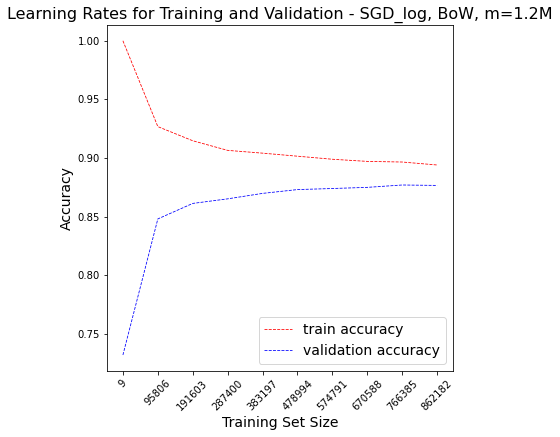

In [14]:
plot_learning_curves_feed_m(SGD_clf_log, X_train_transformed, y_array, 
                           'SGD_log, BoW, m=1.2M')

Interesting, as opposed to the simpler models, SGD actually seems to be on a path to improving classification and we should actually train it on the full $1.2M$ training dataset to see how far we can take this unigram BoW representation.

### Cross Validation 

In [8]:
#score = cross_val_score(NB_clf, X_train_transformed, y_array, cv=5, verbose=3, scoring='accuracy')
#print('Mean accuracy: ' + str(score.mean()))

### Peek at some predictions

In [12]:
#NB_clf.fit(X_train_transformed, y_array)

**Misclassified**

In [9]:
# print misclassifications in first 100 
# y_actual, y_pred, tweet
#misclassified = []
#for i,v in enumerate(NB_clf.predict(X_train_transformed[:100])):
#    if v != y_array[:100][i]:
#        print(y_array[:100][i], v, X_array[:100][i])
#        misclassified.append(i)

In [10]:
#accuracy = 1 - len(misclassified)/100
#print(f'Accuracy in first 100 rows = {accuracy}')

These do seem ambiguous at times, looking at some correctly classified examples.

**Correctly classified**

In [11]:
#for i,v in enumerate(NB_clf.predict(X_train_transformed[:100])):
#    if v == y_array[:100][i] and i < 20:
#        print(y_array[:100][i], v, X_array[:100][i])

And those do seem like more clearcut cases.

In [24]:
# time notebook
mins, secs = divmod(time.time() - start_notebook, 60)
print(f'Total running time: {mins:0.0f} minute(s) and {secs:0.0f} second(s).')

Total running time: 2 minute(s) and 16 second(s).


---